In [2]:
## IMPORTS


from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np



In [31]:
## 1) DATA PREPROCESSING


# Load your dataset
df = pd.read_csv('SaYoPillow 2.csv')  # Update with your actual file path

# Separate the target column ('sl') from the features
X = df.drop(["sl (stress level)"], axis=1)
y = df['sl (stress level)']


#Inspect the data to understand its structure and characteristics.
print(df.head())
df.info()
df.corr()
df.describe()
df.isnull()



   sr (snoing rate)  rr (respiration rate)  t (body temperature)  \
0             48.12                 17.248                97.872   
1             47.00                 16.800                97.200   
2             50.00                 18.000                99.000   
3             45.28                 16.112                96.168   
4             48.60                 17.440                98.160   

   lm (limb movement rate)  bo (body oxygen)  rem (rapid eye movement rate)  \
0                    6.496            96.248                          72.48   
1                    5.600            95.800                          68.00   
2                    8.000            97.000                          80.00   
3                    4.224            95.112                          61.12   
4                    6.880            96.440                          74.40   

   sr (number of hours of sleep)  hr (heart rate)  sl (stress level)  
0                          8.248            5

,sr (snoing rate),rr (respiration rate),t (body temperature),lm (limb movement rate),bo (body oxygen),rem (rapid eye movement rate),sr (number of hours of sleep),hr (heart rate),sl (stress level)
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
625,False,False,False,False,False,False,False,False,False
626,False,False,False,False,False,False,False,False,False
627,False,False,False,False,False,False,False,False,False
628,False,False,False,False,False,False,False,False,False


In [34]:
## 2) DATA AUGMENTATION WITH GAN

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


# # Load your dataset
# data = pd.read_csv("your_dataset.csv")

# # Split data into features (X) and target variable (y)
# X = data.drop("sl (stress level)", axis=1)
# y = data["sl (stress level)"]

# Convert the target variable into one-hot encoded format
y_onehot = pd.get_dummies(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.001, random_state=42)

# Function to define and compile the generator model
def build_generator(latent_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=latent_dim, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_dim, activation='linear')
    ])
    model.compile(loss='mse', optimizer='adam')  # Mean Squared Error for regression task
    return model

# Function to define and compile the discriminator model
def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function to define and compile the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Set discriminator weights as non-trainable during GAN training
    model = tf.keras.Sequential([generator, discriminator])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Function to train the GAN
def train_gan(generator, discriminator, gan, X_train, epochs=500, batch_size=64):
    for epoch in range(epochs):
        # Sample random noise for generator input
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        
        # Generate synthetic data with the generator
        generated_data = generator.predict(noise)
        
        # Create a dataset with a mix of real and generated data
        real_data = X_train.iloc[np.random.randint(0, X_train.shape[0], size=batch_size)]
        labels_real = np.ones((batch_size, 1))
        labels_fake = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_data, labels_real)
        d_loss_fake = discriminator.train_on_batch(generated_data, labels_fake)
        
        # Update the generator via the combined model (gan)
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        labels_gan = np.ones((batch_size, 1))
        
        g_loss = gan.train_on_batch(noise, labels_gan)
        
        # Print the progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

# Function to generate synthetic data using the trained generator
def generate_synthetic_data(generator, num_samples):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    generated_data = generator.predict(noise)
    return generated_data

# Build and train the GAN
latent_dim = 100  # Adjust as needed
output_dim = X_train.shape[1]
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(X_train.shape[1])
gan = build_gan(generator, discriminator)
train_gan(generator, discriminator, gan, X_train)


# Train a RandomForestClassifier on the original data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, np.argmax(y_train.values, axis=1))  # Use the original y_train


# Generate synthetic data using the trained generator
num_synthetic_samples = 650  # adjust as needed
latent_samples = np.random.normal(size=(num_synthetic_samples, latent_dim))
generated_X = generator.predict(latent_samples)

# Use the trained RandomForestClassifier to predict y values for the synthetic data
synthetic_y = np.argmax(rf.predict_proba(generated_X), axis=1)

# Combine original and synthetic data
combined_X = np.vstack([X_train.values, generated_X])

# # Combine original and synthetic y values
# Reshape synthetic_y into a 2D array
synthetic_y = synthetic_y.reshape(-1, 1)

# Combine original and synthetic y values
combined_y = np.concatenate([np.argmax(y_train.values, axis=1).reshape(-1, 1), synthetic_y])



# Convert the combined data to a DataFrame
combinedX_df = pd.DataFrame(combined_X, columns=X_train.columns)

# Save the combined data to a CSV file
combinedX_df.to_csv('combined_data.csv', index=False)

# Convert the combined y values to a DataFrame
# combined_y_df = pd.DataFrame(combined_y, columns=y_train.columns)
# Convert the combined y values to a DataFrame with a single column
combined_y_df = pd.DataFrame(combined_y, columns=['sl (stress level)'])


# Save the combined y values to a CSV file
combined_y_df.to_csv('combined_y.csv', index=False)
#-------------------
# Train a machine learning model using the augmented data
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Choose your model




# Ensure the number of samples in X_augmented and y_augmented are the same
model.fit(combinedX_df, np.argmax(combined_y_df, axis=1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combinedX_df, combined_y_df, test_size=0.04, random_state=49)

# Evaluate the model on the testing set
y_pred = model.predict(X_test)
accuracy = accuracy_score(np.argmax(y_test.values, axis=1), y_pred)
print(f"Accuracy on the testing set: {accuracy}")


# Precision
precision = precision_score(np.argmax(y_test.values, axis=1), y_pred)
print(f"precision on the testing set: {precision}")

# Recall
recall = recall_score(np.argmax(y_test.values, axis=1), y_pred)
print(f"recall on the testing set: {recall}")

# F1 Score
f1 = f1_score(np.argmax(y_test.values, axis=1), y_pred)
print(f"f1 on the testing set: {f1}")


# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test.values, axis=1), y_pred)
print(f"conf_matrix on the testing set: {conf_matrix}")


2/2 [==============================] - 0s 6ms/step
Epoch 0, D Loss Real: 0.9906670451164246, D Loss Fake: 0.7262009382247925, G Loss: 0.6004180908203125
2/2 [==============================] - 0s 7ms/step
Epoch 100, D Loss Real: 1.127197480184838e-14, D Loss Fake: 0.20876187086105347, G Loss: 6.279697418212891
2/2 [==============================] - 0s 3ms/step
Epoch 200, D Loss Real: 3.374974610892423e-08, D Loss Fake: 0.005523715168237686, G Loss: 10.813223838806152
2/2 [==============================] - 0s 14ms/step
Epoch 300, D Loss Real: 0.020951060578227043, D Loss Fake: 0.023999884724617004, G Loss: 8.271671295166016
2/2 [==============================] - 0s 5ms/step
Epoch 400, D Loss Real: 0.0005568749038502574, D Loss Fake: 0.28524288535118103, G Loss: 2.326374053955078
21/21 [==============================] - 0s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWar

Accuracy on the testing set: 1.0
precision on the testing set: 0.0
recall on the testing set: 0.0
f1 on the testing set: 0.0
conf_matrix on the testing set: [[52]]


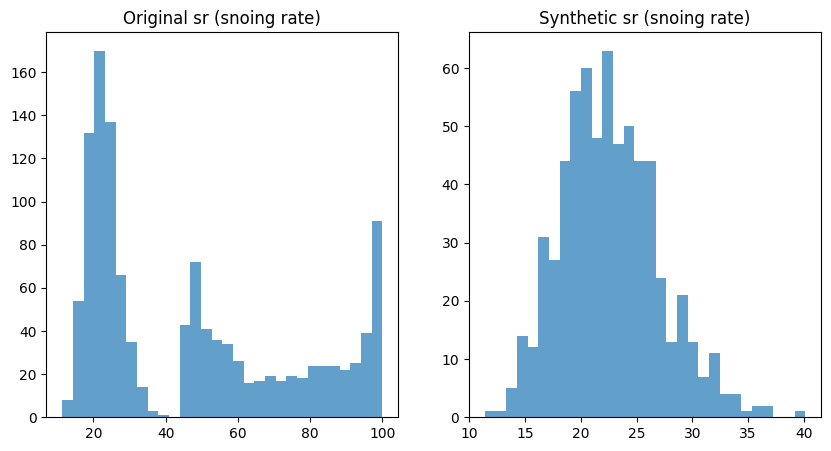

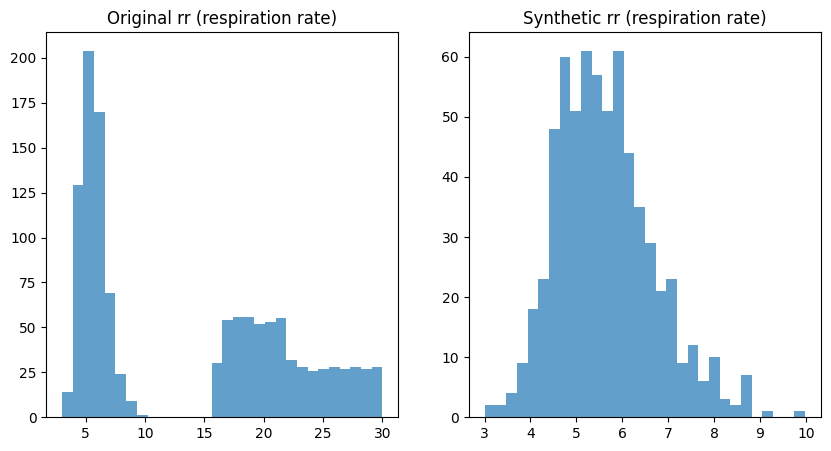

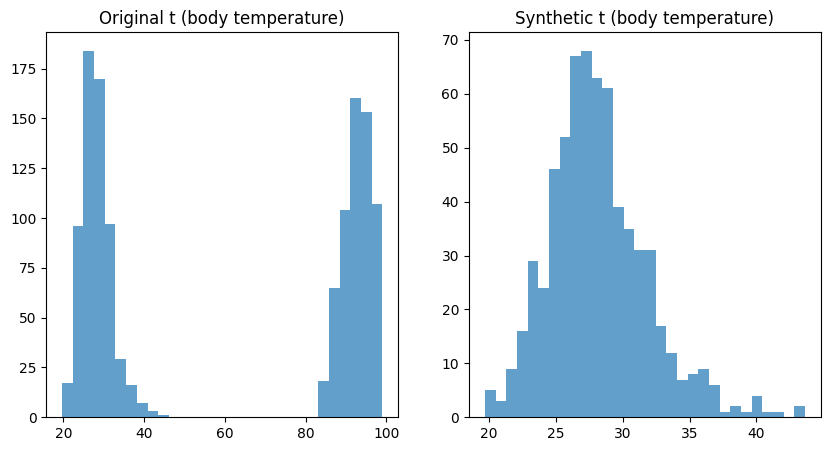

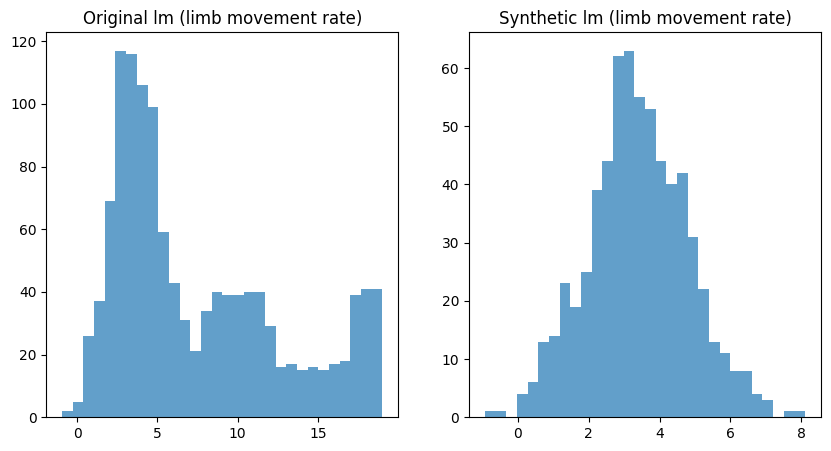

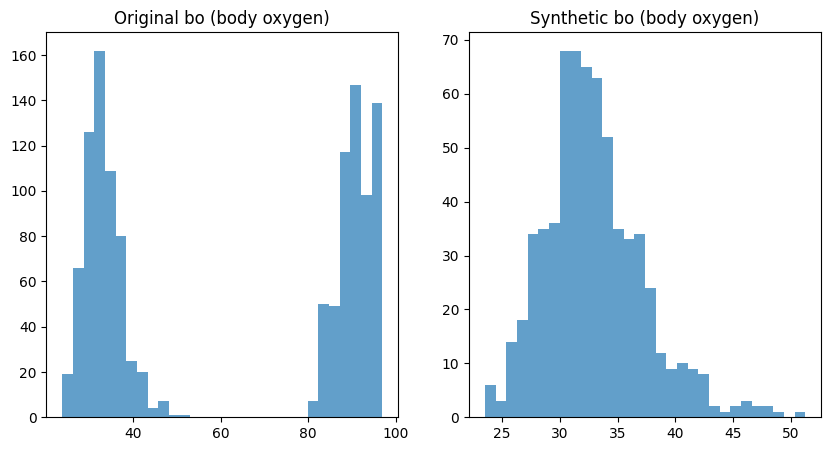

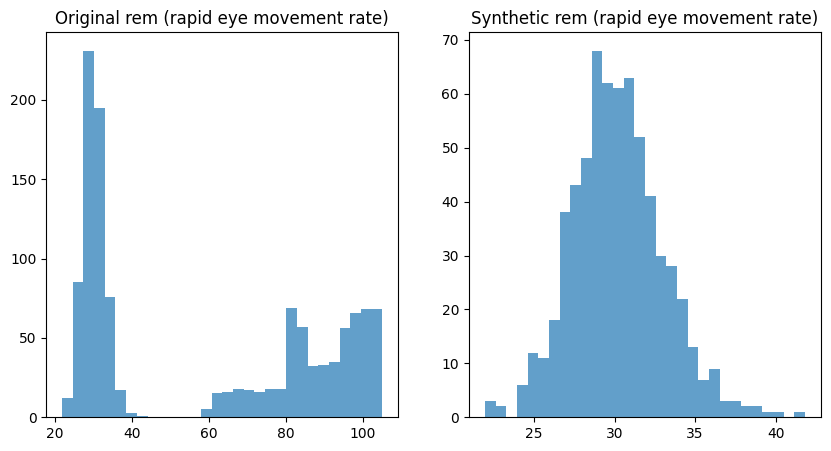

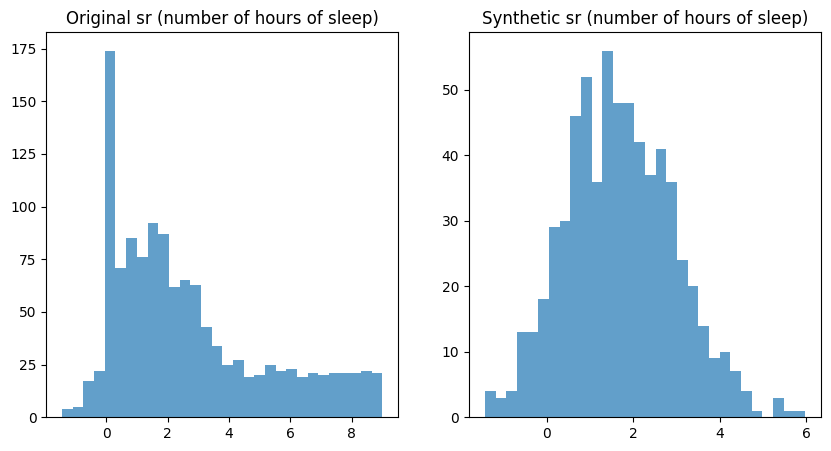

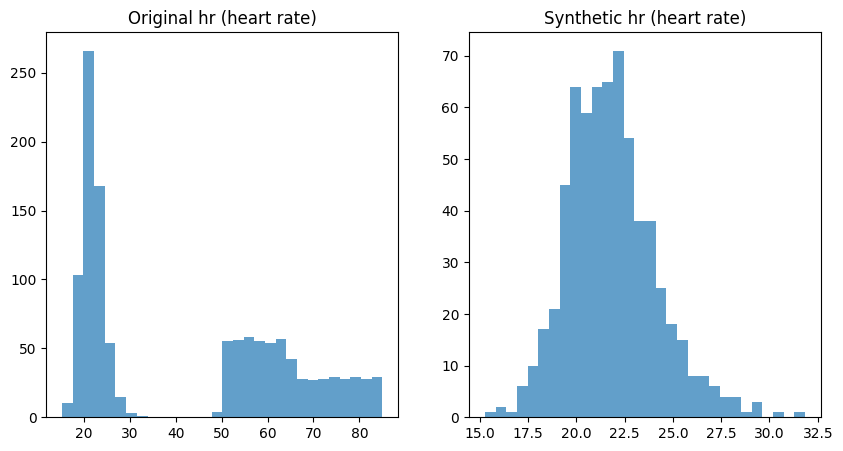

In [35]:
import matplotlib.pyplot as plt

# Convert synthetic data to DataFrame for easier manipulation
generated_X_df = pd.DataFrame(generated_X, columns=X_train.columns)

# For each column in the DataFrame
for column in X_train.columns:
    plt.figure(figsize=(10, 5))

    # Plot histogram of original feature
    plt.subplot(1, 2, 1)
    plt.hist(X_train[column], bins=30, alpha=0.7)
    plt.title(f'Original {column}')

    # Plot histogram of synthetic feature
    plt.subplot(1, 2, 2)
    plt.hist(generated_X_df[column], bins=30, alpha=0.7)
    plt.title(f'Synthetic {column}')

    plt.show()

In [37]:
## 3) FEATURE SELECTION/ ELIMINATION

# 2-degree Polynomialization for all features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(combinedX_df)

columns_poly = poly.get_feature_names_out(combinedX_df.columns)
df_poly = pd.DataFrame(X_poly, columns=columns_poly)

# # Interaction features for all combinations of original features
# X_interact = combinedX_df.copy()
# for col1 in combinedX_df.columns:
#     for col2 in combinedX_df.columns:
#         if col1 != col2:
#             X_interact[f"{col1}_x_{col2}"] = combinedX_df[col1] * combinedX_df[col2]





X_combined= df_poly





# Use MinMaxScaler to normalize the data before GAN
scaler = MinMaxScaler()
X_combined_normalized = scaler.fit_transform(X_combined)

X_combined_normalized

# print(X_combined_normalized.shape)
# print(y.shape)

# Feature Importance with RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_combined_normalized, combined_y_df)


# Get feature importances
importances = rf_classifier.feature_importances_


# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': X_combined.columns, 'importance': importances})
feature_importances

# Sort the DataFrame by importance in descending order
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
feature_importances_sorted

# Select the top n features
n = 5
selected_features_forward_top_n = feature_importances_sorted['feature'].head(n)
selected_features_forward_top_n

# Use the selected features from forward selection
# Convert selected feature names to indices
selected_feature_indices = [np.where(X_combined.columns == feature)[0][0] for feature in selected_features_forward_top_n]
# selected_feature_indices

# # Extract the selected features from X_combined_normalized
X_selected = X_combined_normalized[:, selected_feature_indices]


X_selected


# Convert X_selected to DataFrame and add column names
X_selected_df = pd.DataFrame(X_selected, columns=selected_features_forward_top_n)

# Print the DataFrame
X_selected_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


feature,sr (snoing rate) rr (respiration rate),rr (respiration rate) lm (limb movement rate),rr (respiration rate),rr (respiration rate)^2,sr (snoing rate) lm (limb movement rate)
0,0.360891,0.324666,0.607012,0.411926,0.286563
1,0.873875,0.833265,0.890936,0.811470,0.896095
2,0.391345,0.354111,0.628351,0.437372,0.318715
3,0.875215,0.834996,0.892121,0.813414,0.897201
4,0.995795,0.994325,0.996444,0.993545,0.996540
...,...,...,...,...,...
1274,0.123542,0.148440,0.258446,0.101712,0.176975
1275,0.015910,0.022028,0.056669,0.012951,0.024156
1276,0.033330,0.036024,0.107940,0.029194,0.039414
1277,0.026521,0.034311,0.081642,0.020326,0.040364


In [63]:
## 4) ENSEMBLE LEARNING



from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, combined_y_df, test_size=0.2, random_state=42)

# Create the individual models
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GradientBoostingClassifier(random_state=42)
clf4 = SVC(probability=True, random_state=42)  # Enable probability estimation for SVM
clf5 = GaussianNB()

# Create the ensemble model 1 : Averaging
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gbc', clf3), ('svm', clf4), ('gnb', clf5)],
    voting='soft')  # Use soft voting for averaged ensemble learning

# Fit the ensemble model
eclf.fit(X_train, y_train)

# Make predictions
y_pred = eclf.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)

# print(f"Ensemble accuracy 1: {accuracy}")


# # Accuracy
# accuracy_ensemble = accuracy_score(y_test, y_pred)
# print(f"Ensemble Accuracy: {accuracy_ensemble}")

# # Precision
# precision_ensemble = precision_score(y_test, y_pred, average='weighted')
# print(f"Ensemble Precision: {precision_ensemble}")

# # Recall
# recall_ensemble = recall_score(y_test, y_pred, average='weighted')
# print(f"Ensemble Recall: {recall_ensemble}")

# # F1 Score
# f1_ensemble = f1_score(y_test, y_pred, average='weighted')
# print(f"Ensemble F1 Score: {f1_ensemble}")

# # Confusion Matrix
# conf_matrix_ensemble = confusion_matrix(y_test, y_pred)
# print(f"Ensemble Confusion Matrix:\n{conf_matrix_ensemble}")






# Create the ensemble model 2 : Weighted Averaging

estimators = [('lr', clf1), ('rf', clf2), ('gbc', clf3), ('svm', clf4), ('gnb', clf5)]
weights = [0.10, 0.20, 0.10, 0.20, 0.40]
clf2 = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred2)

# print(f"Ensemble accuracy 2: {accuracy}")


# # Accuracy
# accuracy_ensemble = accuracy_score(y_test, y_pred2)
# print(f"Ensemble Accuracy: {accuracy_ensemble}")

# # Precision
# precision_ensemble = precision_score(y_test, y_pred2, average='weighted')
# print(f"Ensemble Precision: {precision_ensemble}")

# # Recall
# recall_ensemble = recall_score(y_test, y_pred2, average='weighted')
# print(f"Ensemble Recall: {recall_ensemble}")

# # F1 Score
# f1_ensemble = f1_score(y_test, y_pred2, average='weighted')
# print(f"Ensemble F1 Score: {f1_ensemble}")

# # Confusion Matrix
# conf_matrix_ensemble = confusion_matrix(y_test, y_pred2)
# print(f"Ensemble Confusion Matrix:\n{conf_matrix_ensemble}")







# Create the ensemble model 3 : Voting

estimators = [('lr', LogisticRegression()), ('svr', SVC())]
clf3 = VotingClassifier(estimators=estimators, voting='hard')
clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred3)

# print(f"Ensemble accuracy 3: {accuracy}")

# # Precision
# precision_ensemble = precision_score(y_test, y_pred3, average='weighted')
# print(f"Ensemble Precision: {precision_ensemble}")

# # Recall
# recall_ensemble = recall_score(y_test, y_pred3, average='weighted')
# print(f"Ensemble Recall: {recall_ensemble}")

# # F1 Score
# f1_ensemble = f1_score(y_test, y_pred3, average='weighted')
# print(f"Ensemble F1 Score: {f1_ensemble}")

# # Confusion Matrix
# conf_matrix_ensemble = confusion_matrix(y_test, y_pred3)
# print(f"Ensemble Confusion Matrix:\n{conf_matrix_ensemble}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/py

In [58]:
## 5) VOTING
 

In [64]:
## 6) PERFORMANCE EVALUATION

######### Ensemble method 1: 1################

print("\n\n")
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Ensemble accuracy 1: {accuracy}")


# Accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy_ensemble}")

# Precision
precision_ensemble = precision_score(y_test, y_pred, average='weighted')
print(f"Ensemble Precision: {precision_ensemble}")

# Recall
recall_ensemble = recall_score(y_test, y_pred, average='weighted')
print(f"Ensemble Recall: {recall_ensemble}")

# F1 Score
f1_ensemble = f1_score(y_test, y_pred, average='weighted')
print(f"Ensemble F1 Score: {f1_ensemble}")

# Confusion Matrix
conf_matrix_ensemble = confusion_matrix(y_test, y_pred)
print(f"Ensemble Confusion Matrix:\n{conf_matrix_ensemble}")





######### Ensemble method 2: 1################

print("\n\n")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred2)

print(f"Ensemble accuracy 2: {accuracy}")


# Accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred2)
print(f"Ensemble Accuracy: {accuracy_ensemble}")

# Precision
precision_ensemble = precision_score(y_test, y_pred2, average='weighted')
print(f"Ensemble Precision: {precision_ensemble}")

# Recall
recall_ensemble = recall_score(y_test, y_pred2, average='weighted')
print(f"Ensemble Recall: {recall_ensemble}")

# F1 Score
f1_ensemble = f1_score(y_test, y_pred2, average='weighted')
print(f"Ensemble F1 Score: {f1_ensemble}")

# Confusion Matrix
conf_matrix_ensemble = confusion_matrix(y_test, y_pred2)
print(f"Ensemble Confusion Matrix:\n{conf_matrix_ensemble}")


######### Ensemble method 3: 1################




print("\n\n")
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred3)

print(f"Ensemble accuracy 3: {accuracy}")

# Precision
precision_ensemble = precision_score(y_test, y_pred3, average='weighted')
print(f"Ensemble Precision: {precision_ensemble}")

# Recall
recall_ensemble = recall_score(y_test, y_pred3, average='weighted')
print(f"Ensemble Recall: {recall_ensemble}")

# F1 Score
f1_ensemble = f1_score(y_test, y_pred3, average='weighted')
print(f"Ensemble F1 Score: {f1_ensemble}")

# Confusion Matrix
conf_matrix_ensemble = confusion_matrix(y_test, y_pred3)
print(f"Ensemble Confusion Matrix:\n{conf_matrix_ensemble}")




Ensemble accuracy 1: 0.98828125
Ensemble Accuracy: 0.98828125
Ensemble Precision: 0.9888656792953667
Ensemble Recall: 0.98828125
Ensemble F1 Score: 0.9882700197876335
Ensemble Confusion Matrix:
[[147   0   0   0   0]
 [  1  20   0   0   0]
 [  0   0  26   0   0]
 [  0   0   2  33   0]
 [  0   0   0   0  27]]



Ensemble accuracy 2: 0.98046875
Ensemble Accuracy: 0.98046875
Ensemble Precision: 0.9823603823088456
Ensemble Recall: 0.98046875
Ensemble F1 Score: 0.9806767938792958
Ensemble Confusion Matrix:
[[145   2   0   0   0]
 [  0  21   0   0   0]
 [  0   0  26   0   0]
 [  0   0   3  32   0]
 [  0   0   0   0  27]]



Ensemble accuracy 3: 0.9375
Ensemble Precision: 0.9398092558598042
Ensemble Recall: 0.9375
Ensemble F1 Score: 0.9369354390839152
Ensemble Confusion Matrix:
[[147   0   0   0   0]
 [  4  17   0   0   0]
 [  0   5  21   0   0]
 [  0   0   6  28   1]
 [  0   0   0   0  27]]


In [67]:
## 7) UNDERSTANDING THE IMPACT OF EACH FEATURE ON THE MODEL'S PREDICTIONS

# Fit the RandomForest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Print the feature importances
print(feature_importances_sorted)


                                         feature  importance
3                        rr (respiration rate)^2    0.222141
4       sr (snoing rate) lm (limb movement rate)    0.209415
1  rr (respiration rate) lm (limb movement rate)    0.202505
0         sr (snoing rate) rr (respiration rate)    0.201532
2                          rr (respiration rate)    0.164407


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [66]:
# Fit the ensemble model
eclf.fit(X_train, y_train)

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': X_train.columns})

# Get and add feature importances from each base model
for name, clf in eclf.named_estimators_.items():
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = clf.coef_[0]
    else:
        continue

    feature_importances[name] = importances

# Calculate the mean importance of each feature
feature_importances['mean'] = feature_importances.mean(axis=1)

# Sort the DataFrame by mean importance in descending order
feature_importances_sorted = feature_importances.sort_values(by='mean', ascending=False)

# Print the feature importances
print(feature_importances_sorted)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


                                         feature        lr        rf  \
3                        rr (respiration rate)^2 -3.978880  0.222141   
0         sr (snoing rate) rr (respiration rate) -3.947163  0.201532   
2                          rr (respiration rate) -4.148299  0.164407   
4       sr (snoing rate) lm (limb movement rate) -4.424262  0.209415   
1  rr (respiration rate) lm (limb movement rate) -4.728812  0.202505   

        gbc      mean  
3  0.391381 -1.121786  
0  0.078638 -1.222331  
2  0.142603 -1.280429  
4  0.186476 -1.342790  
1  0.200901 -1.441802  


/var/folders/9p/t0bvzfz92xb9hpt1jd_m93t80000gn/T/ipykernel_8023/3191186007.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feature_importances['mean'] = feature_importances.mean(axis=1)


In [68]:
## 8) HYPERPARAMETER TUNING AND ADJUSTING ENSEMBLE LEARNING


from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'lr__C': [0.1, 1.0, 10.0],
    'rf__n_estimators': [50, 100, 200],
    'gbc__n_estimators': [50, 100, 200],
    'svm__C': [0.1, 1.0, 10.0],
    'gnb__var_smoothing': [1e-9, 1e-8, 1e-7]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(eclf, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/py

Best parameters: {'gbc__n_estimators': 50, 'gnb__var_smoothing': 1e-09, 'lr__C': 0.1, 'rf__n_estimators': 50, 'svm__C': 10.0}
Best score: 0.9941367766618843
